# Determination of the market value of real estate

## Project Description

Source data provided by Yandex Real Estate - an archive of advertisements on the sale of apartments in St. Petersburg and neighboring localities for several years. It is necessary to learn how to determine the market value of real estate objects. The main task is to set the parameters. This will help to build an automated system: it will track anomalies and fraudulent activities.

Two types of data are available for each apartment for sale. The first is entered by the user, the second is automatically obtained on the basis of map data. For example, the distance to the center, the airport, the nearest park and body of water.

## Purpose of the study

* Establish the main parameters affecting the value of real estate.

## Steps of the research

* Data review;
* Data preprocessing (filling in gaps, eliminating dibbles and anomalies);
* Hypothesis testing.

# 1. Data review

Import all the necessary libraries to work with the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np

Let's open the file and look at the first lines of data.

In [2]:
try:
    data = pd.read_csv(r'D:\Yandex_Data_Analysis\Project_3\real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('D:\Yandex_Data_Analysis\Project_3\data.csv', sep='\t')

In [3]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

As you can see there are quite a lot of empty and missing values in the table. Let's count their number.

In [5]:
display(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

# 2. Data preprocessing

## 2.1. Identifying and filling in the gaps

Looking at the summary of missing values, you can immediately draw several conclusions:
* Missing values in the column 'balcony' can be replaced by 0, because most likely there are no balconies in these positions, since nothing is specified.
* Missing values in the column 'is_apartment' can also be replaced with False, since this column is of Boolean type.
* In all other columns you cannot change the omissions to 0, since all values and values there are positive.

Let's replace empty values with 0 in the 'balcony' column and False in the 'is_apartment' column. Let's convert all the values in the 'balcony' columns to integers, and the 'is_apartment' column to a boolean type. Then check the result.

In [6]:
data['balcony'] = data['balcony'].fillna(0).astype(int)
data['is_apartment'] = data['is_apartment'].fillna(False).astype(bool)
display(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

### 2.1.1 Find and fix anomalies in the 'ceiling_height' column

В таблице все еще много пустых значений. Постараемся максимально заполнить пропуски там, где это возможно. Начнем с колонки 'ceiling_height'. Проверим, есть ли в данной колонке выбросы.

In [7]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

As you can see the standard deviation from the average is quite large, and also the maximum value of the floor of 100 m is also impossible. According to the building regulations, the height of the ceilings is in the range of 2.4 to 4 m. Let's filter the column by these values and see how many emissions remain.

In [8]:
display(data.query('ceiling_height > 4')['ceiling_height'].count())
display(data.query('ceiling_height < 2.4')['ceiling_height'].count())

75

21

There are only 96 lines with outliers, which is not much, so you can delete them so they don't spoil the data. Then we check the result.

In [9]:
data.drop(data[data['ceiling_height'] > 4].index, inplace = True)
data.drop(data[data['ceiling_height'] < 2.4].index, inplace = True)
display(data.query('ceiling_height > 4')['ceiling_height'].count())
display(data.query('ceiling_height < 2.4')['ceiling_height'].count())

0

0

Now that we've got rid of the outliers, let's fill in the gaps with median values depending on the area and the number of storeys of houses nearby. Then we check how many empty values remain.

In [10]:
data['ceiling_height'] = data['ceiling_height'].fillna(data.groupby(['locality_name', 'floors_total'])['ceiling_height'].
                                                       transform('median'))
display(data['ceiling_height'].describe())
display(data['ceiling_height'].isna().sum())

count    23095.000000
mean         2.705200
std          0.223601
min          2.400000
25%          2.550000
50%          2.650000
75%          2.750000
max          4.000000
Name: ceiling_height, dtype: float64

508

As you can see, there are still empty lines. Assign these gaps the median value of the ceiling height relative to the number of storeys. Then we check the result.

In [11]:
data['ceiling_height'] = data['ceiling_height'].fillna(data.groupby('floors_total')['ceiling_height'].transform('median'))
display(data['ceiling_height'].isna().sum())

78

The remaining empty values will be replaced by the median value of the ceiling height.

In [12]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
display(data['ceiling_height'].isna().sum())

0

Now there are no more gaps.

### 2.1.2 Finding and eliminating anomalies in 'floors_total' columns.

Let's examine the values in the 'floors_total' columns.

In [13]:
display(data['floors_total'].describe())
display(data['floors_total'].isna().sum())

count    23517.000000
mean        10.686907
std          6.594433
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

86

Make sure that there are no lines where the floor on which the apartment is located is greater than the total number of floors.

In [14]:
data.query('floors_total < floor')['floors_total'].count()

0

Fortunately, there are no such lines.
Fill in the empty values with medians relative to the area and the height of the ceilings. Then we check the result.

In [15]:
data['floors_total'] = data['floors_total'].fillna(data.groupby(['locality_name','ceiling_height'])['floors_total'].
                                                   transform('median'))
display(data['floors_total'].describe())
display(data['floors_total'].isna().sum())

count    23599.000000
mean        10.694563
std          6.587489
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

4

Let's replace the remaining empty values with medians relative to the height of the ceilings.

In [16]:
data['floors_total'] = data['floors_total'].fillna(data.groupby('ceiling_height')['floors_total'].transform('median'))
display(data['floors_total'].isna().sum())

0

Now let's make all the values in the 'floors_total' column integer, since there can't be, for example, 1.5 floors.

In [17]:
data['floors_total'] = data['floors_total'].astype(int)

### 2.1.3. Finding and fixing anomalies in the 'days_exposition' column.

In [18]:
data['days_exposition'].isna().sum()

3164

There are quite a few empty values in the 'days_exposition' column. Most likely they mean that the apartment was sold through other sources or on the first day. Therefore, we will replace these values with 0. We will also make all values integers.

In [19]:
data['days_exposition'] = data['days_exposition'].fillna(0).astype(int)

### 2.1.4. Finding and fixing anomalies in the 'living_area' column.

In [20]:
data['living_area'].describe()

count    21709.000000
mean        34.355905
std         21.656306
min          2.000000
25%         18.600000
50%         30.000000
75%         42.200000
max        409.700000
Name: living_area, dtype: float64

According to the Russian building codes SP 54.13330.2016, the minimum living area in a one-room apartment is 14 sq.m. As can be seen from the description of the data, there are abnormally low values. The maximum area is 409 sq.m. structurally acceptable. Let's check how many outliers there are.

In [21]:
display(data.query('living_area < 14')['living_area'].count())
display(data.query('living_area < 14')['living_area'].count()/len(data['living_area'])*100)

322

1.3642333601660805

The number of anomalies is about 1% of all values in the column, so these rows can also be deleted.

In [22]:
data.drop(data[data['living_area'] < 14].index, inplace = True)

Now let's replace the empty values with medians relative to the area and price. Then we check the results.

In [23]:
data['living_area'] = data['living_area'].fillna(data.groupby(['locality_name', 'last_price'])['living_area'].
                                                 transform('median'))
display(data['living_area'].isna().sum())

679

There are still many empty values in the table. Let us replace the remaining ones with the median relative to housing prices.

In [24]:
data['living_area'] = data['living_area'].fillna(data.groupby('last_price')['living_area'].transform('median'))
display(data['living_area'].isna().sum())

308

The remaining gaps will be replaced by the medina of the living area.

In [25]:
data['living_area'] = data['living_area'].fillna(data['living_area'].median())
display(data['living_area'].isna().sum())

0

There are no more empty values.

### 2.1.5. Finding and fixing anomalies in the 'kitchen_area' column.

In [26]:
display(data['kitchen_area'].describe())
display(data['kitchen_area'].isna().sum())

count    21064.000000
mean        10.521765
std          5.862528
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

2217

According to building codes, the minimum kitchen area is 5 sq.m. Let's see how many values are less than this indicator.

In [27]:
display(data.query('kitchen_area < 5')['kitchen_area'].count())

98

In [28]:
data.drop(data[data['kitchen_area'] < 5].index, inplace = True)

There are few such lines, so we will remove these anomalies.

Let's check if there are such lines where total_area < kitchen_area + living_area

In [29]:
data.query('total_area < kitchen_area + living_area')['total_area'].count()

125

These lines with anomalies should also be deleted. Let's create a function that equates all anomalies to 0.

In [30]:
def little_area(row):

    living_area = row['living_area']
    kitchen_area = row['kitchen_area']
    total_area = row['total_area']

    if living_area + kitchen_area > total_area:
        return 0
    else:
        return total_area
    
data['total_area'] = data.apply(little_area, axis=1)

display(data.query('total_area == 0')['total_area'].count())

125

Now let's delete all lines that contain 0. Then check the result.

In [31]:
data.drop(data[data['total_area'] == 0].index, inplace = True)
display(data.query('total_area == 0')['total_area'].count())

0

In our dataset, the kitchen_area column still has a lot of gaps. Let's replace the missing values with the medians relative to the living area and the total area.

In [32]:
data['kitchen_area'] = data['kitchen_area'].fillna(data.groupby(['total_area', 'living_area'])['kitchen_area'].
                                                 transform('median'))
display(data['kitchen_area'].isna().sum())

1556

Now let's replace the missing values with medians, relative to the living area.

In [33]:
data['kitchen_area'] = data['kitchen_area'].fillna(data.groupby('living_area')['kitchen_area'].transform('median'))
display(data['kitchen_area'].isna().sum())

215

The remaining gaps will be replaced by the median values of the kitchen area.

In [34]:
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())
display(data['kitchen_area'].isna().sum())

0

### 2.1.6. Finding and fixing anomalies in the 'airports_nearest' column.

In [35]:
data['airports_nearest'].describe()

count    17722.000000
mean     28769.884663
std      12591.699919
min          0.000000
25%      18574.250000
50%      26726.000000
75%      37242.000000
max      84869.000000
Name: airports_nearest, dtype: float64

According to the Russian standart SNiP 32-03-96, residential buildings cannot be built within a radius of 3 km from the airport. In this regard, let's see how many anomalies there are, less than this indicator.

In [36]:
display(data.query('airports_nearest < 3000')['airports_nearest'].count())

1

This line can simply be removed.

In [37]:
data.drop(data[data['airports_nearest'] < 3000].index, inplace = True)

Let's see how many gaps there are.

In [38]:
data['airports_nearest'].isna().sum()

5336

Fill in the empty values with medians relative to the area and number of floors. Then we check the result.

In [39]:
data['airports_nearest'] = data['airports_nearest'].fillna(data.groupby(['locality_name', 'floors_total'])
                                                           ['airports_nearest'].transform('median'))
data['airports_nearest'].isna().sum()

5238

Let's fill in the empty values with medians relative to the number of floors. Then we check the result.

In [40]:
data['airports_nearest'] = data['airports_nearest'].fillna(data.groupby('floors_total')['airports_nearest'].
                                                           transform('median'))
data['airports_nearest'].isna().sum()

0

### 2.1.7. Finding and fixing anomalies in the 'cityCenters_nearest' column.

First, make sure that the column names are spelled correctly.

In [41]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [42]:
data = data.rename(columns={'cityCenters_nearest':'city_center_nearest'})
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_center_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

Let's analyze the city_center_nearest column for anomalies.

In [43]:
display(data['city_center_nearest'].describe())
display(data['city_center_nearest'].isna().sum())

count    17741.000000
mean     14183.223945
std       8575.483466
min        181.000000
25%       9267.000000
50%      13092.000000
75%      16275.000000
max      65968.000000
Name: city_center_nearest, dtype: float64

5316

There are quite a few empty values. Let's replace them with median values relative to place and price.

In [44]:
data['city_center_nearest'] = data['city_center_nearest'].fillna(data.groupby(['locality_name', 'last_price'])
                                                                 ['city_center_nearest'].transform('median'))
display(data['city_center_nearest'].isna().sum())

5265

Now let's replace the remaining gaps with the median relative to the price.

In [45]:
data['city_center_nearest'] = data['city_center_nearest'].fillna(data.groupby('last_price')
                                                                 ['city_center_nearest'].transform('median'))
display(data['city_center_nearest'].isna().sum())

1174

The remaining gaps are replaced by the median relative to the distance to the center.

In [46]:
data['city_center_nearest'] = data['city_center_nearest'].fillna(data['city_center_nearest'].median())
display(data['city_center_nearest'].isna().sum())

0

### 2.1.8. Finding and fixing anomalies in the 'parks_around3000' column.

Let's analyze the parks_around3000 column for anomalies.

In [47]:
display(data['parks_around3000'].describe())
display(data['parks_around3000'].isna().sum())

count    17742.000000
mean         0.611149
std          0.801411
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64

5315

There are also quite a few missing ones. Let's replace gaps with median values relative to place and price.

In [48]:
data['parks_around3000'] = data['parks_around3000'].fillna(data.groupby(['locality_name', 'last_price'])
                                                                 ['parks_around3000'].transform('median'))
display(data['parks_around3000'].isna().sum())

5265

Now let's replace the remaining gaps with the median relative to the price.

In [49]:
data['parks_around3000'] = data['parks_around3000'].fillna(data.groupby('last_price')
                                                                 ['parks_around3000'].transform('median'))
display(data['parks_around3000'].isna().sum())

1174

The remaining gaps are replaced by the median relative to the distance to the center.

In [50]:
data['parks_around3000'] = data['parks_around3000'].fillna(data['parks_around3000'].median())
display(data['parks_around3000'].isna().sum())

0

Since there are no more gaps, let's change the data type to integers, rounding up. Then we check the result.

In [51]:
data['parks_around3000'] = data['parks_around3000'].apply(np.ceil).astype(int)

In [52]:
display(data['parks_around3000'].value_counts())

0    14795
1     5786
2     1841
3      635
Name: parks_around3000, dtype: int64

### 2.1.9. Finding and fixing anomalies in the 'parks_nearest' column

In [53]:
display(data['parks_nearest'].describe())
display(data['parks_nearest'].isna().sum())

count    7887.000000
mean      490.793204
std       340.639156
min         1.000000
25%       288.000000
50%       455.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64

15170

The distance to the park of 1 m seems suspicious. It would be more logical to assume that the minimum distance to the park can be at least 10m. Let's see how many such values there are.

In [54]:
display(data.query('parks_nearest < 10')['parks_nearest'].count())

6

There are not many such lines, we will delete them.

In [55]:
data.drop(data[data['parks_nearest'] < 10].index, inplace = True)

Now let's replace the empty values with the median relative to location and parks within a 3000m radius.

In [56]:
data['parks_nearest'] = data['parks_nearest'].fillna(data.groupby(['locality_name', 'parks_around3000'])
                                                                 ['parks_nearest'].transform('median'))
display(data['parks_nearest'].isna().sum())

6919

Let's replace the remaining gaps with medians relative to parks within a radius of 3000 m.

In [57]:
data['parks_nearest'] = data['parks_nearest'].fillna(data.groupby('parks_around3000')
                                                                 ['parks_nearest'].transform('median'))
display(data['parks_nearest'].isna().sum())

0

### 2.1.10. Finding and fixing anomalies in the 'ponds_nearest' column

Let's analyze the ponds_nearest column for anomalies.

In [58]:
display(data['ponds_nearest'].describe())
display(data['ponds_nearest'].isna().sum())

count    8847.000000
mean      518.507969
std       277.562652
min        13.000000
25%       294.000000
50%       503.000000
75%       730.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

14204

Most likely in those locations where there are gaps, the distance to the nearest body of water is too large to accurately indicate it. Since there are quite a lot of such rows (more than half of the entire dataset), we will not change them in any way so as not to accidentally distort the final results.

In [59]:
#data['ponds_nearest'] = data['ponds_nearest'].fillna(0)
#display(data['ponds_nearest'].value_counts())

# 3. Search and removal of duplicates.

Let's check the number of obvious duplicates.

In [59]:
data.duplicated().sum()

0

Check the rest of the columns for implicit duplicates. Let's check the column with the names of locations.

In [60]:
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

When analyzing the unique values, it became noticeable that there are several implicit duplicates in terms of the spelling of the word 'посёлок' and 'поселок'. Replace duplicates with 'посёлок'. Let's check the results.

In [61]:
data['locality_name'] = data['locality_name'].str.replace('поселок','посёлок')
display(data['locality_name'].sort_values().unique())

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской посёлок Большая Ижора', 'городской посёлок Будогощь',
       'городской посёлок Виллози', 'городской посёлок Лесогорский',
       'городской посёлок Мга', 'городской посёлок Назия',
       'городской посёлок Новоселье', 'городской посёлок Павлово',
       'городской посёлок Рощино', 'городской посёлок Свирьстрой',
       'городской посёлок Советский', 'городской посёлок Фёд

There are no more duplicates.

# 4. Adding new data

## 4.1. Price per square meter

Calculate and add the price per square meter for each value, rounded up.

In [62]:
data['price_per_meter'] = round(data['last_price']/data['total_area']).astype(int)
data.head(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,False,...,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2.0,755.0,0,120370
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.77,11,18.6,1,False,...,2,посёлок Шушары,12817.0,18603.0,0,3127.0,0.0,NaN,81,82921
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.60,5,34.3,4,False,...,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2.0,574.0,558,92786


## 4.2. Date of announcement

Let's edit the 'first_day_exposition' column to make it readable. Add columns with the day of the week, month and year.

In [63]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
day_expo = data['first_day_exposition'].dt.day_name()
data.insert(4, 'day_exposition', day_expo)
month_expo = data['first_day_exposition'].dt.month
data.insert(5, 'month_exposition', month_expo)
year_expo = data['first_day_exposition'].dt.year
data.insert(6, 'year_exposition', year_expo)
data.head(3)

,total_images,last_price,total_area,first_day_exposition,day_exposition,month_exposition,year_exposition,rooms,ceiling_height,floors_total,...,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter
0,20,13000000.0,108.0,2019-03-07,Thursday,3,2019,3,2.70,16,...,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2.0,755.0,0,120370
1,7,3350000.0,40.4,2018-12-04,Tuesday,12,2018,1,2.77,11,...,2,посёлок Шушары,12817.0,18603.0,0,3127.0,0.0,NaN,81,82921
2,10,5196000.0,56.0,2015-08-20,Thursday,8,2015,2,2.60,5,...,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2.0,574.0,558,92786


## 4.3. Floor category

Let's create a column where we assign categories of floors relative to the location of the object. Categories for floors of the apartment will be assigned as follows: first, last, other. Let's write a function to implement this.

In [64]:
def floor_category(row):

    floor = row['floor']
    total_floors = row['floors_total']

    if floor == 1:
        return 'первый'
    elif floor == total_floors:
        return 'последний'
    else:
        return 'другой'
    
data['floor_category'] = data.apply(floor_category, axis=1)

display(data.head(3))

,total_images,last_price,total_area,first_day_exposition,day_exposition,month_exposition,year_exposition,rooms,ceiling_height,floors_total,...,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,floor_category
0,20,13000000.0,108.0,2019-03-07,Thursday,3,2019,3,2.70,16,...,Санкт-Петербург,18863.0,16028.0,1,482.0,2.0,755.0,0,120370,другой
1,7,3350000.0,40.4,2018-12-04,Tuesday,12,2018,1,2.77,11,...,посёлок Шушары,12817.0,18603.0,0,3127.0,0.0,NaN,81,82921,первый
2,10,5196000.0,56.0,2015-08-20,Thursday,8,2015,2,2.60,5,...,Санкт-Петербург,21741.0,13933.0,1,90.0,2.0,574.0,558,92786,другой


## 4.4. The ratio of residential and total areas, the ratio of the area of ​​the kitchen to the total.

Let's add columns in which we indicate the correlation between the areas.

In [65]:
data['living_to_total'] = (data['living_area']/data['total_area']).round(decimals = 2)
data['kitchen_to_total'] = (data['kitchen_area']/data['total_area']).round(decimals = 2)
pd.set_option('display.max_columns', None)
data.head(5)

,total_images,last_price,total_area,first_day_exposition,day_exposition,month_exposition,year_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,floor_category,living_to_total,kitchen_to_total
0,20,13000000.0,108.0,2019-03-07,Thursday,3,2019,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2.0,755.0,0,120370,другой,0.47,0.23
1,7,3350000.0,40.4,2018-12-04,Tuesday,12,2018,1,2.77,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0,3127.0,0.0,NaN,81,82921,первый,0.46,0.27
2,10,5196000.0,56.0,2015-08-20,Thursday,8,2015,2,2.60,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2.0,574.0,558,92786,другой,0.61,0.15
3,0,64900000.0,159.0,2015-07-24,Friday,7,2015,3,2.60,14,30.0,9,False,False,False,8.5,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3.0,234.0,424,408176,другой,0.19,0.05
4,2,10000000.0,100.0,2018-06-19,Tuesday,6,2018,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1.0,48.0,121,100000,другой,0.32,0.41


# 5. Research Analysis

## 5.1. Площадь, цена, число комнат, высота потолков.

Let's study the relationship between the above parameters. Let's construct histograms for each parameter.

We will also translate the values of the last_price column into millions for further convenience.

In [66]:
data['last_price'] = data['last_price']/1000000

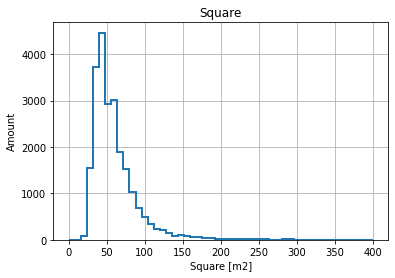

In [70]:
area = data['total_area'].plot(kind='hist',
histtype='step',
range=(0, 400),
bins=50,
linewidth=2,
grid=True, title='Square')
area.set_xlabel('Square [m2]')
area.set_ylabel('Amount');

The schedule meets expectations. As you can see, the most common area is 50 sq.m. Number of apartments with an area of more than 150 sq.m. measured in units.

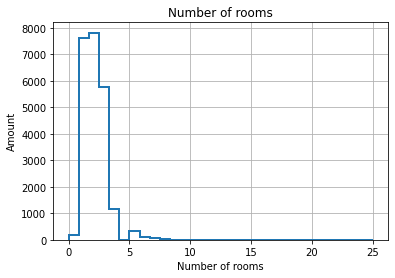

In [71]:
rooms = data['rooms'].plot(kind='hist',
histtype='step',
range=(0, 25),
bins=30,
linewidth=2,
grid=True, title='Number of rooms')
rooms.set_xlabel('Number of rooms')
rooms.set_ylabel('Amount');

Some anomalies are noticeable on the schedule, for example, apartments with zero room values. Most likely, these values mean studios. Let's test this hypothesis.

In [72]:
display(data.query('rooms == 0').groupby('studio')['rooms'].count())
display(data.query('rooms == 0')['rooms'].count())

studio
False     55
True     129
Name: rooms, dtype: int64

184

The hypothesis was partially confirmed - most of the apartments with zero room value are studios. The remaining 55 objects can be recognized as outliers. Also suspicious are apartments with more than 10 rooms. The most common options are 2 and 3 room apartments.

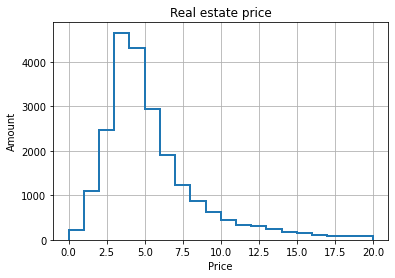

In [73]:
price = data['last_price'].plot(kind='hist',
histtype='step',
range=(0, 20),
bins=20,
linewidth=2,
grid=True, title='Real estate price')
price.set_xlabel('Price')
price.set_ylabel('Amount');

As can be seen from the graph, the largest number of apartments are in the price range from 2.5 to 5 million. Apartments over 20 million are calculated in units, so we do not indicate them on the graph.

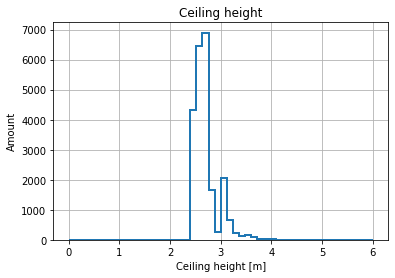

In [75]:
ceiling = data['ceiling_height'].plot(kind='hist',
histtype='step',
range=(0, 6),
bins=50,
linewidth=2,
grid=True, title='Ceiling height')
ceiling.set_xlabel('Ceiling height [m]')
ceiling.set_ylabel('Amount');

The graph shows that the average ceiling height is 2.5 m.

## 5.2. Selling time

Let's analyze the time of sale of apartments.

In [76]:
display(data['days_exposition'].describe())
display(data.query('days_exposition == 0')['days_exposition'].count())

count    23051.000000
mean       156.844822
std        213.803239
min          0.000000
25%         23.000000
50%         74.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

3100

As you can see, there are quite a lot of null values in the data.

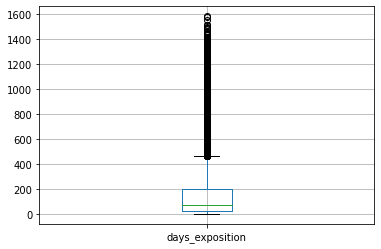

In [77]:
boxplot = data.boxplot(column=['days_exposition'])

There are also many outliers in the range diagram. This suggests that sales that exceed 450 days can be considered unusually long. Let's discard the obvious outliers and look at the result.

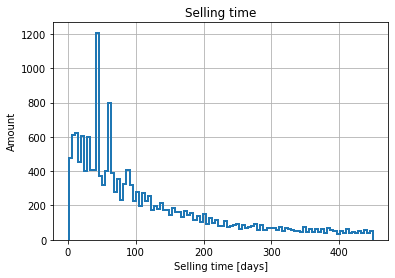

In [79]:
expo = data['days_exposition'].plot(kind='hist',
histtype='step',
range=(1, 450),
bins=100,
linewidth=2,
grid=True, title='Selling time')
expo.set_xlabel('Selling time [days]')
expo.set_ylabel('Amount');

According to the chart, the fastest sales occur within one month. The average time to sell an apartment takes about 2 months.

## 5.3. Factors that most affect the value of an apartment

Find out if the price depends on the area, number of rooms, distance from the center. Study the dependence of the price on which floor the apartment is located on: first, last or another. Also study the dependence on the date of placement: day of the week, month and year.

In [80]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'day_exposition', 'month_exposition', 'year_exposition', 'rooms',
       'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_center_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'price_per_meter', 'floor_category',
       'living_to_total', 'kitchen_to_total'],
      dtype='object')

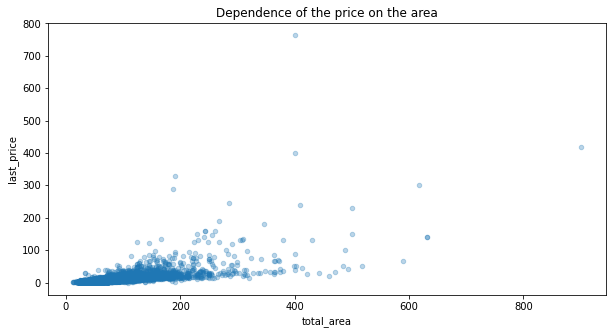

In [82]:
data.plot(x='total_area', y='last_price', kind='scatter', title = 'Dependence of the price on the area',
          figsize=(10, 5), alpha=0.3);

As you can see, the larger the area, the higher the price. Most real estate options are in the range of 200 sq.m. and cost up to 5 million

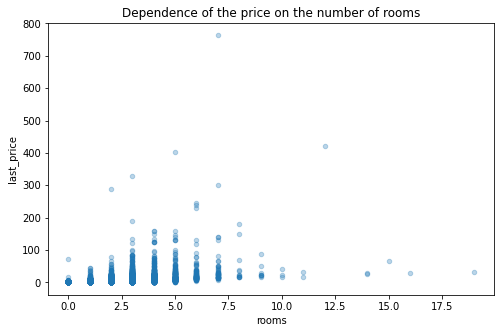

In [83]:
data.plot(x='rooms', y='last_price', kind='scatter', title = 'Dependence of the price on the number of rooms',
          figsize=(8, 5), alpha=0.3);

On average, the price is in the range of up to 10 million. The largest range of prices falls on 2 and 3-room apartments. One-room apartments and studios cost up to 5 million rubles.

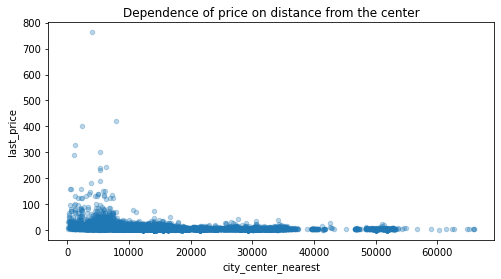

In [84]:
data.plot(x='city_center_nearest', y='last_price', kind='scatter', 
          title = 'Dependence of price on distance from the center', figsize=(8, 4), alpha=0.3);

As expected - the closer to the center, the more expensive. But the average price is in the range of 5 million.

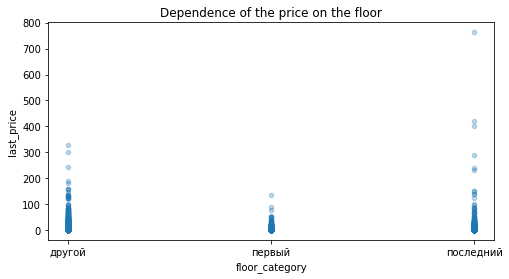

In [85]:
data.plot(x='floor_category', y='last_price', kind='scatter', title = 'Dependence of the price on the floor',
          figsize=(8, 4), alpha=0.3);

The lowest prices for apartments located on the first floor. The highest ones are on the last one.

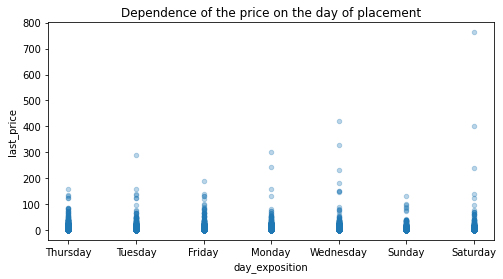

In [86]:
data.plot(x='day_exposition', y='last_price', kind='scatter', title = 'Dependence of the price on the day of placement',
          figsize=(8, 4), alpha=0.3);

The price is approximately the same and does not depend much on the day of placement on the market.

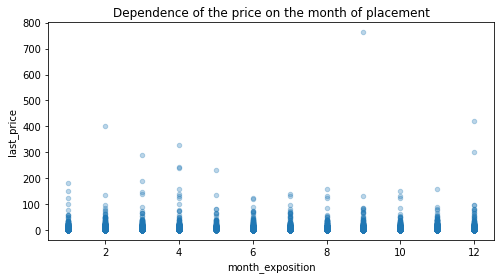

In [87]:
data.plot(x='month_exposition', y='last_price', kind='scatter',
          title = 'Dependence of the price on the month of placement', figsize=(8, 4), alpha=0.3);

The same situation with the month of placement. The price doesn't matter.

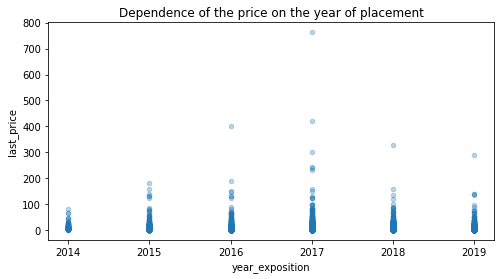

In [88]:
data.plot(x='year_exposition', y='last_price', kind='scatter', title = 'Dependence of the price on the year of placement',
          figsize=(8, 4), alpha=0.3);

In 2017, real estate prices were slightly higher compared to other years.

## 5.4. Dependence of the price of real estate on the location.

1) Let's choose 10 settlements with the largest number of ads.

In [89]:
most_popular_estate = data.pivot_table(index='locality_name', values='price_per_meter', aggfunc=['count', 'median'])
most_popular_estate.columns = ['number', 'median']
most_popular_estate = most_popular_estate.sort_values(by='number', ascending=False)
most_popular_estate.head(10)

,number,median
locality_name,,
Санкт-Петербург,15354,104444.0
посёлок Мурино,520,85452.5
посёлок Шушары,421,75918.0
Всеволожск,386,65667.5
Пушкин,363,99987.0
Колпино,335,74725.0
посёлок Парголово,306,90873.0
Гатчина,294,67746.5
деревня Кудрово,293,92000.0


2) Display the average price per square meter in these settlements.

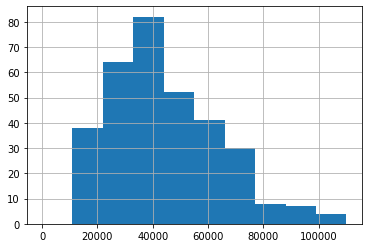

In [90]:
most_popular_estate['median'].hist(bins=10, range=(0, 110000))
plt.show()

As you can see from the graph, the average price per square meter is 40,000.

3) Find the settlements with the highest and lowest cost of housing.

In [91]:
most_popular_estate['median'].describe()

count       326.000000
mean      44270.254601
std       19663.880428
min       11000.000000
25%       30385.500000
50%       40347.750000
75%       56636.750000
max      104444.000000
Name: median, dtype: float64

In [92]:
display(most_popular_estate.query('median == 11000'))
display(most_popular_estate.query('median == 104444'))

,number,median
locality_name,,
деревня Старополье,3,11000.0


,number,median
locality_name,,
Санкт-Петербург,15354,104444.0


As can be seen in the village of Staropolye, the lowest cost of housing, while in St. Petersburg the highest.

## 5.5. Analysis of prices for apartments in the center of St. Petersburg

1) Let's create a pivot table that will contain information about real estate in St. Petersburg and the distance from the center.

In [93]:
spb_estate = data.query('locality_name == "Санкт-Петербург"')
spb_estate['city_center_nearest'] = (spb_estate['city_center_nearest']/1000).astype(int)
spb_centre = spb_estate.pivot_table(index='city_center_nearest', values='last_price', aggfunc='mean')
display(spb_centre.head(10))

C:\Users\nikit\AppData\Local\Temp\ipykernel_12680\3255050705.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spb_estate['city_center_nearest'] = (spb_estate['city_center_nearest']/1000).astype(int)


,last_price
city_center_nearest,
0,23.898014
1,18.583324
2,16.376396
3,13.782101
4,13.495192
5,15.060223
6,14.326342
7,12.882156
8,8.490581


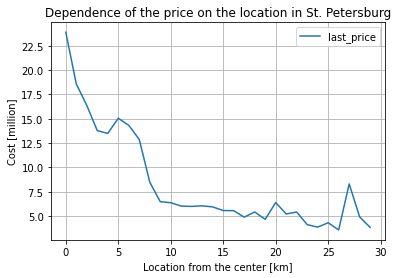

In [95]:
spb_centre_plot = spb_centre.plot(kind='line',
grid=True, title='Dependence of the price on the location in St. Petersburg')
spb_centre_plot.set_xlabel('Location from the center [km]')
spb_centre_plot.set_ylabel('Cost [million]');

It is noticeable on the chart that the price changes sharply down at around 5 km. Obviously this is the boundary of the center.

## 5.6. Factors affecting the price of apartments in the center of St. Petersburg

Let's display a table with real estate in the center of St. Petersburg.

In [96]:
spb_center_estate = spb_estate.query('city_center_nearest <= 5')
spb_center_estate.head(5)

,total_images,last_price,total_area,first_day_exposition,day_exposition,month_exposition,year_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,floor_category,living_to_total,kitchen_to_total
24,8,6.50,97.2,2015-10-31,Saturday,10,2015,2,3.0,3,46.5,1,False,False,False,19.6,0,Санкт-Петербург,20052.0,2,3,411.0,3.0,124.0,265,66872,первый,0.48,0.20
35,6,15.50,149.0,2017-06-26,Monday,6,2017,5,2.6,5,104.0,4,False,False,False,17.0,0,Санкт-Петербург,23670.0,3,0,3127.0,1.0,779.0,644,104027,другой,0.70,0.11
61,18,7.99,74.0,2017-08-24,Thursday,8,2017,2,3.0,4,43.0,4,False,False,False,20.0,0,Санкт-Петербург,22568.0,4,1,363.0,0.0,NaN,609,107973,последний,0.58,0.27
63,2,20.00,118.0,2018-09-11,Tuesday,9,2018,3,3.0,9,68.0,7,False,False,False,16.0,0,Санкт-Петербург,26055.0,4,1,648.0,1.0,779.0,37,169492,другой,0.58,0.14
99,32,9.60,90.0,2017-09-26,Tuesday,9,2017,4,2.6,5,67.0,2,False,False,False,8.0,0,Санкт-Петербург,23277.0,2,0,3127.0,0.0,NaN,104,106667,другой,0.74,0.09


**1) First, let's analyze the following parameters: area, price, number of rooms, ceiling height.** 

In [97]:
spb_center_estate[['total_area','last_price','rooms','ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,2749.000000,2749.000000,2749.000000,2749.000000
mean,96.503383,15.023356,2.976719,3.010582
std,59.375178,25.409162,1.498727,0.323499
min,13.000000,1.686000,0.000000,2.400000
25%,60.000000,6.950000,2.000000,2.750000
50%,83.000000,9.500000,3.000000,3.000000
75%,113.200000,14.790000,4.000000,3.200000
max,631.200000,763.000000,19.000000,4.000000


*In total, 613 apartments are on sale in the center of St. Petersburg. Average area from 100 sq.m. The average number of rooms is 3. The average ceiling height is 3m. Average cost - 18 million *

**2) Let's see how the following factors relate to real estate in the center: number of rooms, floor, distance from the center, date of placement of the ad and price.**

                        rooms     floor  city_center_nearest  year_exposition  \
rooms                1.000000 -0.024205            -0.108856        -0.044641   
floor               -0.024205  1.000000             0.201046        -0.047725   
city_center_nearest -0.108856  0.201046             1.000000         0.015832   
year_exposition     -0.044641 -0.047725             0.015832         1.000000   
last_price           0.287589  0.127026            -0.057681        -0.031287   

                     last_price  
rooms                  0.287589  
floor                  0.127026  
city_center_nearest   -0.057681  
year_exposition       -0.031287  
last_price             1.000000  


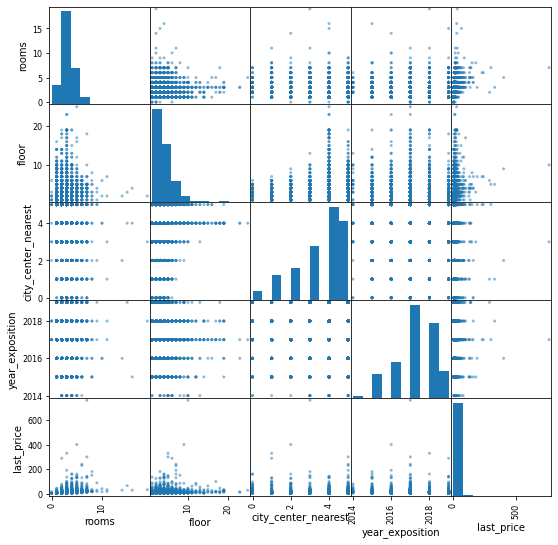

In [98]:
spb_center_metrics = spb_center_estate[['rooms','floor','city_center_nearest', 'year_exposition', 'last_price']]
pd.plotting.scatter_matrix(spb_center_metrics, figsize=(9, 9))
print(spb_center_metrics.corr()) 

*Based on the scatterplot and correlation matrix, it is noticeable that almost all real estate metrics in the center have very little effect on each other. It is noticeable that the price in the center is slightly affected by the floor and the number of rooms.*

**3) Let's compare the received results with the general information on all real estate objects.**

                        rooms     floor  city_center_nearest  year_exposition  \
rooms                1.000000 -0.149041            -0.195897        -0.053084   
floor               -0.149041  1.000000            -0.037070         0.004682   
city_center_nearest -0.195897 -0.037070             1.000000         0.029693   
year_exposition     -0.053084  0.004682             0.029693         1.000000   
last_price           0.358468  0.028411            -0.224947        -0.040740   

                     last_price  
rooms                  0.358468  
floor                  0.028411  
city_center_nearest   -0.224947  
year_exposition       -0.040740  
last_price             1.000000  


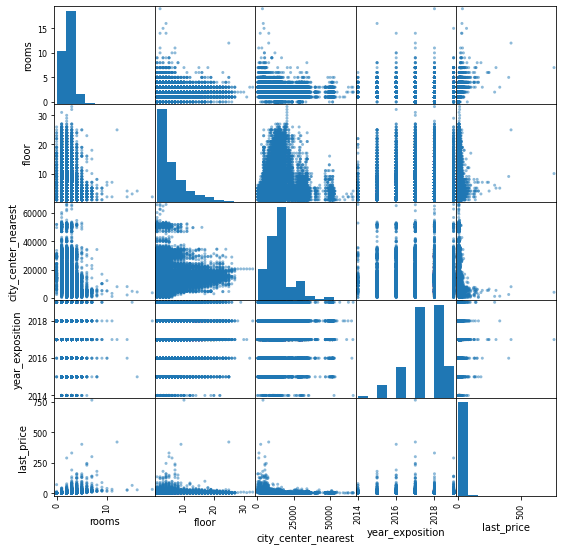

In [99]:
estate_metrics = data[['rooms','floor','city_center_nearest', 'year_exposition', 'last_price']]
pd.plotting.scatter_matrix(estate_metrics, figsize=(9, 9))
print(estate_metrics.corr()) 

*It is noticeable that in other locations the number of rooms decreases with the floor, in contrast to the center of St. Petersburg. Also in the region, the floor of the apartment decreases as you approach the center. In addition, in other cities, the number of rooms decreases the closer to the center. Also on the charts you can see that the price increases from the following factors: proximity to the center, with an increase in rooms and floors.*

# 6. Conclusion

Based on the analysis, several general conclusions can be drawn:
* For all properties, the price, as a rule, increases the most from the area, distance from the center, the number of rooms, as well as the floor;
* Real estate in the center of St. Petersburg is quite stable and little dependent on any factors;
* On real estate properties other than the center of St. Petersburg, there is an inverse relationship with respect to the main factors affecting the price.